In [1210]:
import os
import numpy as np
import scipy.io.wavfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [1227]:
def process_mfcc_5days(file_path, sample_rate=1258, return_as='df'):
    # 讀取音頻檔案
    signal = scipy.io.wavfile.read(file_path)[1]
    frame_size = 0.008
    frame_stride = 0.008

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

    # 信號的總長度，將幀長度和步長四捨五入到最接近的整數，並計算總幀數
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)+1)
    print(signal_length)
    print(frame_length)
    print(frame_step)
    print(num_frames)

    # 確保音頻信號的長度足以被完全切割成幀。如果信號太短，它將用零填充到適當的長度。
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # 每個幀都乘以了漢明窗，減少幀的邊緣處的信號不連續性
    frames *= np.hamming(frame_length)
  
    NFFT = 512

    # 執行 FFT 轉換並計算幅度
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # 計算頻率軸的值
    freqs = np.fft.rfftfreq(NFFT, 1.0 / sample_rate)
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # 計算對數能量
    log_energy = np.log(np.sum(pow_frames, axis=1))

    # 設定梅爾濾波器組參數
    n_filters = 40  # 梅爾濾波器的數量
    low_freq_mel = 0  # 最低的梅爾頻率
    high_freq_mel = (2595 * np.log10(1 + (sample_rate/2) / 700))  # 最高的梅爾頻率

    # 計算梅爾點
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # 等間隔的梅爾頻率
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # 將梅爾頻率轉換回赫茲頻率

    # 計算濾波器邊界在FFT窗中的位置
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    # 創建濾波器組
    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bin[m - 1])   # 左邊界
        f_m = int(bin[m])             # 中心點
        f_m_plus = int(bin[m + 1])    # 右邊界

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    # 應用濾波器組到功率谱上
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
   
    # 計算對數濾波器銀行能量
    filter_banks = np.log(filter_banks)

    # 離散餘弦變換以得到MFCC
    num_ceps = 12
    mfccs = scipy.fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: num_ceps+1]

    # 計算MFCC的一階和二階差分
    # delta_mfccs = np.diff(mfccs, n=1, axis=0)
    # delta_mfccs = np.vstack([np.zeros(delta_mfccs.shape[1]), delta_mfccs])  
    # delta2_mfccs = np.diff(delta_mfccs, n=1, axis=0)
    # delta2_mfccs = np.vstack([np.zeros(delta2_mfccs.shape[1]), delta2_mfccs])  # 首行補零
    
    # 將原始的MFCC特徵、一階差分和二階差分合併
    mfccs_features = np.hstack([mfccs, log_energy.reshape(-1, 1)])
    # mfccs_features = np.hstack([mfccs, delta_mfccs])


    # # 進行特徵歸一化
    # mfccs_features -= np.mean(mfccs_features, axis=0)

    # # 初始化MinMaxScaler並將特徵縮放到0到1之間
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # mfccs_scaled = scaler.fit_transform(mfccs_features)

    # 創建 MFCC DataFrame
    # mfccs_df = pd.DataFrame(mfccs, columns=[f"MFCC{i+1}" for i in range(mfccs.shape[1])])
    
    num_mfcc_features = 13
    mfccs_df = pd.DataFrame(mfccs_features, columns=[f"MFCC_{i+1}" for i in range(num_mfcc_features)] )
    # mfccs_df = pd.DataFrame(mfccs_features, columns=[f"MFCC_{i+1}" for i in range(num_mfcc_features)] + 
                                                #    [f"Delta_{i+1}" for i in range(num_mfcc_features)] )


    print(mfccs_features.shape)
    print("MFCCs scaled max:", np.max(mfccs_features))
    print("MFCCs scaled min:", np.min(mfccs_features))

    return mfccs_df

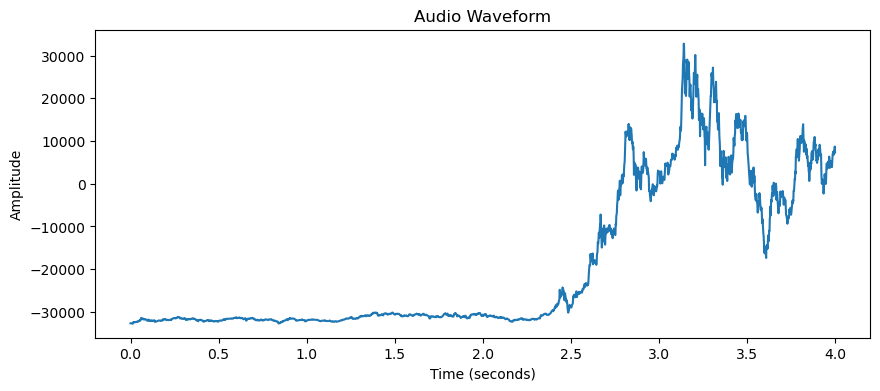

In [1228]:
def plot_audio_waveform(file_path):
    # 讀取音頻檔案
    sample_rate, signal = scipy.io.wavfile.read(file_path)

    # 計算時間軸數據
    time_axis = np.linspace(0, len(signal) / sample_rate, num=len(signal))

    # 繪製波形圖
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, signal)
    plt.title("Audio Waveform")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

# 指定要繪製波形圖的音頻檔案路徑
file_path = "tslaopen_stockPriceAudio.wav"
plot_audio_waveform(file_path)

收盤價

In [1229]:
# 讀取音頻檔案並提取 MFCC 特徵
close_mfcc_df5 = process_mfcc_5days("tsla_stockPriceAudio.wav")

# 將 DataFrame 轉換為 NumPy 數組
close_mfcc_df5 = close_mfcc_df5.to_numpy()

# 顯示 MFCC 特徵數組
print(close_mfcc_df5)

5032
10
10
504
(504, 13)
MFCCs scaled max: 22.868929870428325
MFCCs scaled min: -8.036875775101567
[[ 2.21300013e+01  6.63880281e+00 -4.34504007e+00 ...  1.58708379e+00
  -5.58256943e-01  2.13847082e+01]
 [ 2.21858366e+01  6.56596892e+00 -4.42346821e+00 ...  1.71678234e+00
  -6.57241283e-01  2.13845886e+01]
 [ 2.21023110e+01  6.68332209e+00 -4.31894682e+00 ...  1.52514265e+00
  -5.18281180e-01  2.13658507e+01]
 ...
 [ 2.01325722e+01  5.67596805e+00 -8.80098083e-01 ...  1.56802097e-01
  -1.56764807e+00  1.83486161e+01]
 [ 2.12375424e+01  5.99500994e+00 -3.76859457e+00 ...  1.04983464e+00
  -7.59570796e-01  1.84686984e+01]
 [ 2.51690446e+00 -1.21358864e+00  3.60016941e-01 ...  1.80188322e-02
   7.70135825e-03  1.36722267e+01]]


開盤價

In [1230]:
# # 讀取音頻檔案並提取 MFCC 特徵
# open_mfcc_df = process_mfcc("tslaopen_stockPriceAudio.wav")

# # 將 DataFrame 轉換為 NumPy 數組
# open_mfcc_features = open_mfcc_df.to_numpy()

# # 顯示 MFCC 特徵數組
# print(open_mfcc_features)

最高點

In [1215]:
# # 讀取音頻檔案並提取 MFCC 特徵
# high_mfcc_df = process_mfcc("tslahigh_stockPriceAudio.wav")

# # 將 DataFrame 轉換為 NumPy 數組
# high_mfcc_features = high_mfcc_df.to_numpy()

# # 顯示 MFCC 特徵數組
# print(high_mfcc_features)

最低點

In [1216]:
# # 讀取音頻檔案並提取 MFCC 特徵
# low_mfcc_df = process_mfcc("tslalow_stockPriceAudio.wav")

# # 將 DataFrame 轉換為 NumPy 數組
# low_mfcc_features = low_mfcc_df.to_numpy()

# # 顯示 MFCC 特徵數組
# print(low_mfcc_features)

成交量

In [1231]:
# 讀取音頻檔案並提取 MFCC 特徵
volume_mfcc_df = process_mfcc_5days("tslavolume_stockPriceAudio.wav")

# 將 DataFrame 轉換為 NumPy 數組
volume_mfcc_features = volume_mfcc_df.to_numpy()

# 顯示 MFCC 特徵數組
print(volume_mfcc_features)

5032
10
10
504
(504, 13)
MFCCs scaled max: 24.89508432901443
MFCCs scaled min: -8.821060618418409
[[ 2.14023823e+01  6.02254310e+00 -2.96786102e+00 ...  6.71604867e-01
  -7.39908482e-01  2.10596284e+01]
 [ 1.25527939e+01 -1.48441969e+00  1.27807517e+00 ...  4.44969949e-01
  -3.53790709e-01  2.04033748e+01]
 [ 2.02935624e+01  4.06883176e+00 -3.52768563e-01 ...  5.61110992e-01
  -1.23029239e+00  2.07513209e+01]
 ...
 [ 2.20033612e+01  6.17103216e+00 -4.34574358e+00 ...  1.59771814e+00
  -5.26301629e-01  2.07973438e+01]
 [ 2.23252818e+01  5.45956197e+00 -4.35068303e+00 ...  1.93194483e+00
  -1.02083799e+00  2.09757882e+01]
 [ 2.26129806e+00 -1.07861196e+00  2.87338874e-01 ...  1.62143112e-02
   8.93662266e-03  1.64608843e+01]]


In [1232]:
mfcc_features = np.concatenate(
    (close_mfcc_df5, volume_mfcc_features),
    axis=1
)


mfcc_features.shape

(504, 26)

In [1233]:
def process_mel_spectrogram(file_path, sample_rate=1258):
    # 讀取音頻檔案
    signal = scipy.io.wavfile.read(file_path)[1]
    frame_size = 0.008
    frame_stride = 0.008

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

    # 信號的總長度，將幀長度和步長四捨五入到最接近的整數，並計算總幀數
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step) + 1)

    # 確保音頻信號的長度足以被完全切割成幀。如果信號太短，它將用零填充到適當的長度。
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # 每個幀都乘以了漢明窗，減少幀的邊緣處的信號不連續性
    frames *= np.hamming(frame_length)
  
    NFFT = 512

    # 執行 FFT 轉換並計算幅度
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # 計算頻率軸的值
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # 設定梅爾濾波器組參數
    n_filters = 22  # 梅爾濾波器的數量
    low_freq_mel = 0  # 最低的梅爾頻率
    high_freq_mel = (2595 * np.log10(1 + (sample_rate/2) / 700))  # 最高的梅爾頻率

    # 計算梅爾點
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # 等間隔的梅爾頻率
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # 將梅爾頻率轉換回赫茲頻率

    # 計算濾波器邊界在FFT窗中的位置
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    # 創建濾波器組
    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bin[m - 1])   # 左邊界
        f_m = int(bin[m])             # 中心點
        f_m_plus = int(bin[m + 1])    # 右邊界

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    # 應用濾波器組到功率谱上
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
   
    # 計算對數濾波器銀行能量
    filter_banks = np.log(filter_banks)

    return filter_banks

def plot_mel_spectrogram(mel_spectrogram, title='Mel Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram.T, aspect='auto', origin='lower', interpolation='none')
    plt.title(title)
    plt.ylabel('Mel Frequency Bands')
    plt.xlabel('Frames')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

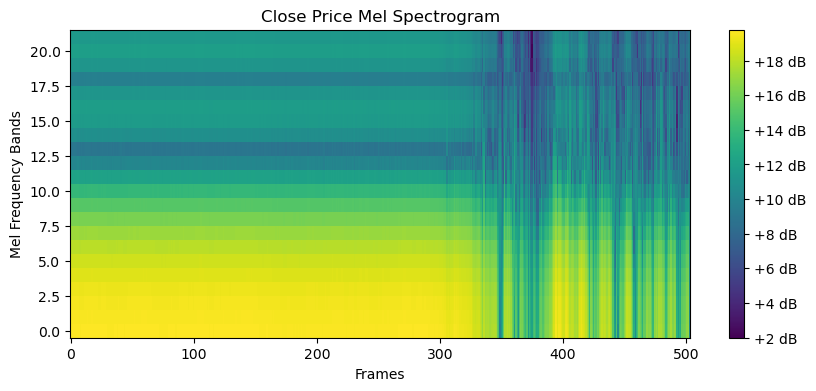

In [1234]:
# 讀取音頻檔案並提取梅爾頻譜
close_mel_spectrogram = process_mel_spectrogram("tsla_stockPriceAudio.wav")

# 繪製梅爾頻譜圖
plot_mel_spectrogram(close_mel_spectrogram, title='Close Price Mel Spectrogram')

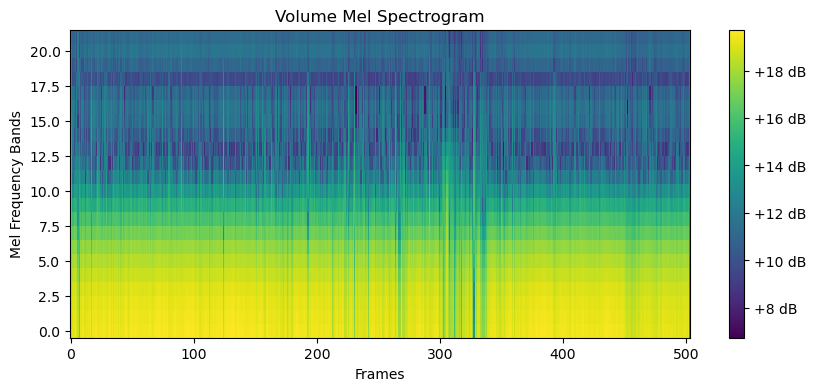

In [1235]:
# 讀取音頻檔案並提取梅爾頻譜
volume_mel_spectrogram = process_mel_spectrogram("tslavolume_stockPriceAudio.wav")

# 繪製梅爾頻譜圖
plot_mel_spectrogram(volume_mel_spectrogram, title='Volume Mel Spectrogram')

頻譜圖數據

In [1236]:
import python_speech_features as psf

def calculate_magnitude_spectrum_5days(file_path, sample_rate=1258, frame_size=0.008, frame_stride=0.008, NFFT=13):
    # 讀取音頻檔案
    signal = scipy.io.wavfile.read(file_path)[1]

    # 計算幀長和步長
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)+1)

    # 確保音頻信號的長度足以被完全切割成幀
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # 每個幀都乘以了漢明窗
    frames *= np.hamming(frame_length)
  
    # 執行 FFT 轉換並計算幅度譜
    mag_frames = psf.sigproc.magspec(frames, NFFT)

    # 對幅度譜進行對數變換
    log_mag_frames = np.log1p(mag_frames)

    return log_mag_frames

In [1237]:
close_file_path = 'tsla_stockPriceAudio.wav'
close_magnitude_spectrum_5days = calculate_magnitude_spectrum_5days(close_file_path)
print(close_magnitude_spectrum_5days.shape)

(504, 7)


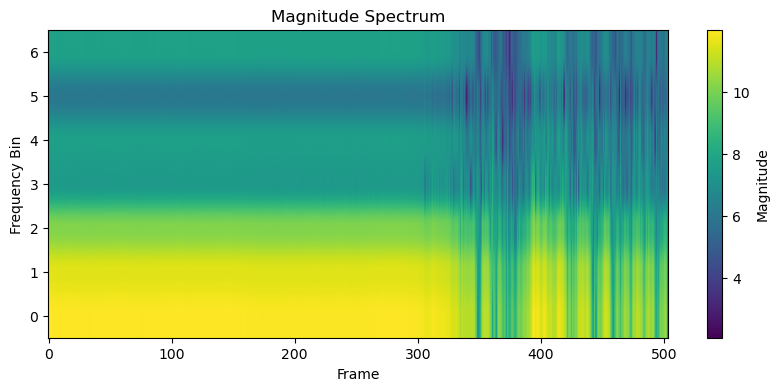

In [1238]:
# 視覺化幅度譜
plt.figure(figsize=(10, 4))
plt.imshow(close_magnitude_spectrum_5days.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Magnitude Spectrum')
plt.ylabel('Frequency Bin')
plt.xlabel('Frame')
plt.colorbar(label='Magnitude')
plt.show()

In [1239]:
volume_file_path = 'tslavolume_stockPriceAudio.wav'
volume_magnitude_spectrum_5days = calculate_magnitude_spectrum_5days(volume_file_path)
print(volume_magnitude_spectrum_5days.shape)

(504, 7)


In [1240]:
close_mfcc_df5_with_magnitude = np.concatenate([mfcc_features, close_magnitude_spectrum_5days,volume_magnitude_spectrum_5days], axis=-1)

In [1241]:
print(close_mfcc_df5_with_magnitude.shape)

(504, 40)


加入真實值

In [ ]:
# # 讀取CSV文件
# df = pd.read_csv('Tesla_Close_Prices_2023.csv', parse_dates=['Date'])

# # 確保數據按日期排序
# df.sort_values('Date', inplace=True)

# # 使用股價數據的長度來決定要處理的幀數
# prices_every_five_days = df.iloc[4::5, :]['Close'].values  # 從第四天開始，每隔五天取一個數據

# # 調整 MFCC 特徵數組的長度以匹配股價數據的長度
# if prices_every_five_days.shape[0] < close_mfcc_df5_with_magnitude.shape[0]:
#     mfcc_features_df5 = close_mfcc_df5_with_magnitude[:prices_every_five_days.shape[0], :]

# # 檢查現在的數據長度
# if prices_every_five_days.shape[0] != mfcc_features_df5.shape[0]:
#     raise ValueError("提取的股價數據與調整後的 MFCC 幀數仍不匹配。")

# # 將股價數據添加到 MFCC 特徵數組中
# mfcc_with_prices_df5 = np.hstack((mfcc_features_df5, prices_every_five_days.reshape(-1, 1)))

# print("MFCC with Stock Prices 5days:")
# print(mfcc_with_prices_df5.shape)

In [ ]:
# # 讀取CSV文件
# df = pd.read_csv('Tesla_Close_Prices_2023.csv', parse_dates=['Date'])

# # 確保數據按日期排序
# df.sort_values('Date', inplace=True)

# # 使用所有的股價數據
# prices_every_day = df.iloc[4:, :]['Close'].values  # 從第五天開始取所有數據

# # 檢查 MFCC 特徵數組和股價數據的長度
# mfcc_features_df5_length = min(len(prices_every_day), close_mfcc_df5_with_magnitude.shape[0])
# mfcc_features_df5 = close_mfcc_df5_with_magnitude[:mfcc_features_df5_length, :]
# prices_every_day = prices_every_day[:mfcc_features_df5_length]

# # 檢查現在的數據長度
# if prices_every_day.shape[0] != mfcc_features_df5.shape[0]:
#     raise ValueError("提取的股價數據與調整後的 MFCC 幀數仍不匹配。")

# # 將股價數據添加到 MFCC 特徵數組中
# mfcc_with_prices_df5 = np.hstack((mfcc_features_df5, prices_every_day.reshape(-1, 1)))

# print("MFCC with Stock Prices for every day from day 5:")
# print(mfcc_with_prices_df5.shape)

reshape_20_days

In [1242]:
# 假設 mfcc_with_prices_df5 是您的原始數據集 (503, 21)
data = np.array(close_mfcc_df5_with_magnitude)

# 計算新的數據集中的樣本數
num_samples = (data.shape[0] - 4 + 1)  # 從數據集的最後一個frame往前計算

# 創建一個新的數據集來存儲20天的數據
mfcc_with_prices_df20 = np.zeros((num_samples, 4, 40))  # 初始化數組

for i in range(num_samples):
    mfcc_with_prices_df20[i] = data[i:i+4]  # 擷取連續的4個frame

# twenty_day_dataset 的形狀將是 (num_samples, 4, 21)，其中 num_samples 是計算得出的樣本數
print("MFCC with Stock Prices 20days:", mfcc_with_prices_df20.shape)

MFCC with Stock Prices 20days: (501, 4, 40)


reshape_60_days

In [1243]:
# 計算新的數據集中的樣本數
num_samples = (data.shape[0] - 12 + 1)  # 從數據集的最後一個frame往前計算

# 創建一個新的數據集來存儲60天的數據
mfcc_with_prices_df60 = np.zeros((num_samples, 12, 40))  # 初始化數組

for i in range(num_samples):
    mfcc_with_prices_df60[i] = data[i:i+12]  # 擷取連續的12個frame

# sixty_day_dataset 的形狀將是 (num_samples, 12, 21)，其中 num_samples 是計算得出的樣本數
print("MFCC with Stock Prices 60days:", mfcc_with_prices_df60.shape)

MFCC with Stock Prices 60days: (493, 12, 40)


In [1244]:
# 假設 five_day_dataset 是五天的數據集，twenty_day_dataset 是二十天的數據集
five_day_dataset = np.array(close_mfcc_df5_with_magnitude)
twenty_day_dataset = np.array(mfcc_with_prices_df20)  # 這需要您已經有一個名為 twenty_day_dataset 的變數

# 調整五天的數據集
adjusted_five_day_dataset = five_day_dataset[11:]  # 刪除前11個樣本

# 調整二十天的數據集
adjusted_twenty_day_dataset = twenty_day_dataset[8:]  # 刪除前8個樣本

print("5days:", adjusted_five_day_dataset.shape)
print("20days:", adjusted_twenty_day_dataset.shape)
print("60days:",mfcc_with_prices_df60.shape)

5days: (493, 40)
20days: (493, 4, 40)
60days: (493, 12, 40)


標記label

In [1245]:
# 讀取CSV檔案
df = pd.read_csv('Tesla_Close_Prices_2023.csv')


In [1246]:
# 設定價格變動的閾值
threshold = 0.01

# 初始化標籤列表
labels = ['0']  # 將第一天標記為持平

# 使用 for 迴圈遍歷股價數據，從第二個交易日開始
for i in range(1, len(df)):
    # 計算前一天和當天的股價變化百分比
    price_change = (df['Close'].iloc[i] - df['Close'].iloc[i - 1]) / df['Close'].iloc[i - 1]
    
    # 判斷價格變動並分配標籤
    if price_change > threshold:
        labels.append('1')  # 上漲
    elif price_change < -threshold:
        labels.append('-1')  # 下跌
    else:
        labels.append('0')  # 持平

# 將標籤列表添加到原始數據的副本中
data_with_labels = df.copy()
data_with_labels['Label'] = labels

# 將標籤轉換為獨熱編碼
labels_one_hot = pd.get_dummies(data_with_labels['Label'])

# 將布林型態的獨熱編碼轉換為整數型態
labels_one_hot = labels_one_hot.astype(int)

# 將獨熱編碼的標籤添加回原數據集
data_with_labels_one_hot = pd.concat([data_with_labels, labels_one_hot], axis=1)

# 顯示帶有獨熱編碼標籤的 DataFrame 頭部數據
print(data_with_labels_one_hot.head(10))


         Date      Close Label  -1  0  1
0  2014-01-02  10.006667     0   0  1  0
1  2014-01-03   9.970667     0   0  1  0
2  2014-01-06   9.800000    -1   1  0  0
3  2014-01-07   9.957333     1   0  0  1
4  2014-01-08  10.085333     1   0  0  1
5  2014-01-09   9.835333    -1   1  0  0
6  2014-01-10   9.714667    -1   1  0  0
7  2014-01-13   9.289333    -1   1  0  0
8  2014-01-14  10.751333     1   0  0  1
9  2014-01-15  10.942000     1   0  0  1


In [1247]:
len(data_with_labels_one_hot)

2516

In [1248]:
# 打印原始標籤數據集和特徵數據集的形狀以檢查對齊
print("Original data_with_labels_one_hot shape:", data_with_labels_one_hot.shape)
print("Original adjusted_five_day_dataset shape:", adjusted_five_day_dataset.shape)


Original data_with_labels_one_hot shape: (2516, 6)
Original adjusted_five_day_dataset shape: (493, 40)


In [1249]:
# # 計算最大的索引，使其為5的倍數
# max_index = (data_with_labels_one_hot.shape[0] // 5) * 5

# # 每五天選取最後一天的標籤
# labels_every_five_days = data_with_labels_one_hot.iloc[4:max_index:5]  # 從索引4開始，每隔5個取一個，不超過max_index

# # 刪除前11個標籤以匹配調整後的特徵數據集
# adjusted_labels = labels_every_five_days.iloc[11:]

# # 檢查調整後的標籤數量是否與調整後的特徵數據集行數匹配
# if adjusted_labels.shape[0] != adjusted_five_day_dataset.shape[0]:
#     raise ValueError("調整後的標籤數量與特徵數據的行數不匹配，請檢查對齊情況。")

# # 標籤獨熱編碼列名
# label_columns = ['-1', '0', '1']  # 根據您的具體列名進行調整

# # 提取調整後的獨熱編碼的標籤部分
# adjusted_label_values = adjusted_labels[label_columns].values

# # 檢查數據，可選操作
# print("調整後的特徵數據形狀:", adjusted_five_day_dataset.shape)
# print("調整後的標籤數據形狀:", adjusted_label_values.shape)

In [1250]:
# 從索引4開始，每天選取一個標籤，並刪除前15個標籤以匹配調整後的特徵數據集
labels_every_day = data_with_labels_one_hot.iloc[:]
adjusted_labels = labels_every_day.iloc[15:15 + adjusted_five_day_dataset.shape[0]]

# 打印調整後的標籤數據集和特徵數據集的形狀以檢查對齊
print("Adjusted labels shape:", adjusted_labels.shape)
print("Adjusted five_day_dataset shape:", adjusted_five_day_dataset.shape)

# 檢查調整後的標籤數量是否與調整後的特徵數據集行數匹配
if adjusted_labels.shape[0] != adjusted_five_day_dataset.shape[0]:
    raise ValueError("調整後的標籤數量與特徵數據的行數不匹配，請檢查對齊情況。")

# 標籤獨熱編碼列名
label_columns = ['-1', '0', '1']  # 根據您的具體列名進行調整

# 提取調整後的獨熱編碼的標籤部分
adjusted_label_values = adjusted_labels[label_columns].values

# 檢查數據，可選操作
print("調整後的特徵數據形狀:", adjusted_five_day_dataset.shape)
print("調整後的標籤數據形狀:", adjusted_label_values.shape)

Adjusted labels shape: (493, 6)
Adjusted five_day_dataset shape: (493, 40)
調整後的特徵數據形狀: (493, 40)
調整後的標籤數據形狀: (493, 3)


In [1251]:
a5 =  adjusted_five_day_dataset
a20 = adjusted_twenty_day_dataset
a60 = mfcc_with_prices_df60

b = adjusted_label_values

print(a5.shape ,a20.shape, a60.shape, b.shape)

(493, 40) (493, 4, 40) (493, 12, 40) (493, 3)


In [1302]:
# 定義數據集大小和切割比例
data_size = a5.shape[0]
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# 計算各數據集的大小
train_size = int(data_size * train_ratio)
val_size = int(data_size * val_ratio)
test_size = data_size - train_size - val_size

# 生成隨機索引
indices = np.arange(data_size)
np.random.shuffle(indices)

# 按比例切割索引
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# 根據索引切割數據集
X_train_5, X_val_5, X_test_5 = a5[train_indices], a5[val_indices], a5[test_indices]
X_train_20, X_val_20, X_test_20 = a20[train_indices], a20[val_indices], a20[test_indices]
X_train_60, X_val_60, X_test_60 = a60[train_indices], a60[val_indices], a60[test_indices]
y_train, y_val, y_test = b[train_indices], b[val_indices], b[test_indices]

# 檢查分割結果
print(f"Training set shapes: {X_train_5.shape}, {X_train_20.shape}, {X_train_60.shape}, {y_train.shape}")
print(f"Validation set shapes: {X_val_5.shape}, {X_val_20.shape}, {X_val_60.shape}, {y_val.shape}")
print(f"Testing set shapes: {X_test_5.shape}, {X_test_20.shape}, {X_test_60.shape}, {y_test.shape}")

Training set shapes: (345, 40), (345, 4, 40), (345, 12, 40), (345, 3)
Validation set shapes: (98, 40), (98, 4, 40), (98, 12, 40), (98, 3)
Testing set shapes: (50, 40), (50, 4, 40), (50, 12, 40), (50, 3)


In [1303]:
from collections import Counter

# 將one-hot編碼轉換為類別標籤
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 計算每個數據集中的標籤數量
train_label_counts = Counter(y_train_labels)
val_label_counts = Counter(y_val_labels)
test_label_counts = Counter(y_test_labels)

# 打印標籤計數
print("Training set label counts:")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count}")

print("\nValidation set label counts:")
for label, count in val_label_counts.items():
    print(f"Label {label}: {count}")

print("\nTesting set label counts:")
for label, count in test_label_counts.items():
    print(f"Label {label}: {count}")

# 計算每個數據集中的標籤比例
train_label_ratios = {label: count / len(y_train_labels) for label, count in train_label_counts.items()}
val_label_ratios = {label: count / len(y_val_labels) for label, count in val_label_counts.items()}
test_label_ratios = {label: count / len(y_test_labels) for label, count in test_label_counts.items()}

# 打印結果
print("\nTraining set label ratios:")
for label, ratio in train_label_ratios.items():
    print(f"Label {label}: {ratio:.2%}")

print("\nValidation set label ratios:")
for label, ratio in val_label_ratios.items():
    print(f"Label {label}: {ratio:.2%}")

print("\nTesting set label ratios:")
for label, ratio in test_label_ratios.items():
    print(f"Label {label}: {ratio:.2%}")

Training set label counts:
Label 0: 104
Label 2: 108
Label 1: 133

Validation set label counts:
Label 1: 38
Label 2: 32
Label 0: 28

Testing set label counts:
Label 1: 17
Label 2: 19
Label 0: 14

Training set label ratios:
Label 0: 30.14%
Label 2: 31.30%
Label 1: 38.55%

Validation set label ratios:
Label 1: 38.78%
Label 2: 32.65%
Label 0: 28.57%

Testing set label ratios:
Label 1: 34.00%
Label 2: 38.00%
Label 0: 28.00%


In [1304]:
# 对每个时间尺度的数据进行标准化
scaler_5 = StandardScaler().fit(X_train_5)
X_train_5 = scaler_5.transform(X_train_5)
X_val_5 = scaler_5.transform(X_val_5)
X_test_5 = scaler_5.transform(X_test_5)

# 对20天数据进行标准化
scaler_20 = StandardScaler().fit(X_train_20.reshape(-1, X_train_20.shape[-1]))
X_train_20 = scaler_20.transform(X_train_20.reshape(-1, X_train_20.shape[-1])).reshape(X_train_20.shape)
X_val_20 = scaler_20.transform(X_val_20.reshape(-1, X_val_20.shape[-1])).reshape(X_val_20.shape)
X_test_20 = scaler_20.transform(X_test_20.reshape(-1, X_test_20.shape[-1])).reshape(X_test_20.shape)

# 对60天数据进行标准化
scaler_60 = StandardScaler().fit(X_train_60.reshape(-1, X_train_60.shape[-1]))
X_train_60 = scaler_60.transform(X_train_60.reshape(-1, X_train_60.shape[-1])).reshape(X_train_60.shape)
X_val_60 = scaler_60.transform(X_val_60.reshape(-1, X_val_60.shape[-1])).reshape(X_val_60.shape)
X_test_60 = scaler_60.transform(X_test_60.reshape(-1, X_test_60.shape[-1])).reshape(X_test_60.shape)

模型訓練

In [1305]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten, GlobalAveragePooling1D,  LeakyReLU, Dropout,TimeDistributed
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal,HeNormal,HeUniform

In [1317]:
# 建立三個獨立的分支
# 分支1: 處理每5天的數據
input_5 = Input(shape=(40,))
dense_5 = Dense(16)(input_5)
leaky_relu_5 = LeakyReLU(alpha=0.01)(dense_5)

# 分支2: 處理每20天的數據
input_20 = Input(shape=(4, 40))
lstm_20 = LSTM(16, activation='tanh', return_sequences=True)(input_20)
time_distributed_20 = TimeDistributed(Dense(12, activation='tanh'))(lstm_20)
flatten_20 = Flatten()(time_distributed_20)

# 分支3: 處理每60天的數據
input_60 = Input(shape=(12, 40))
lstm_60 = LSTM(16, activation='tanh', return_sequences=True)(input_60)
time_distributed_60 = TimeDistributed(Dense(12, activation='tanh'))(lstm_60)
flatten_60 = Flatten()(time_distributed_60)

# 合併所有分支的輸出
concat = Concatenate()([leaky_relu_5, flatten_20, flatten_60])
dropout_1 = Dropout(0.2)(concat)
dense_1 = Dense(128, kernel_regularizer=l2(0.1))(dropout_1)
# dense_1 = Dense(128, kernel_regularizer=l2(0.05))(dropout_1)
leaky_relu_concat_1 = LeakyReLU(alpha=0.01)(dense_1)
dropout_2 = Dropout(0.1)(leaky_relu_concat_1)

dense_2 = Dense(24, kernel_regularizer=l2(0.05))(dropout_2)
leaky_relu_concat_2 = LeakyReLU(alpha=0.01)(dense_2)
# dropout_2 = Dropout(0.1)(leaky_relu_concat_2)
output = Dense(3, activation='softmax')(leaky_relu_concat_2)

# 設置學習率
learning_rate = 0.0001 
optimizer = Adam(learning_rate=learning_rate)

# 建立和編譯模型
model = Model(inputs=[input_5, input_20, input_60], outputs=output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 模型摘要
model.summary()


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_121 (InputLayer)      [(None, 4, 40)]              0         []                            
                                                                                                  
 input_122 (InputLayer)      [(None, 12, 40)]             0         []                            
                                                                                                  
 input_120 (InputLayer)      [(None, 40)]                 0         []                            
                                                                                                  
 lstm_78 (LSTM)              (None, 4, 16)                3648      ['input_121[0][0]']           
                                                                                           

In [1318]:
# 定義學習率衰減回調
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=0.000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    [X_train_5, X_train_20, X_train_60], y_train,
    validation_data=([X_val_5, X_val_20, X_val_60], y_val),
    epochs=800,batch_size=128,
    shuffle=True, callbacks=[reduce_lr,early_stopping]
)

Epoch 1/800


2024-06-18 20:54:12.960246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-18 20:54:13.407315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-18 20:54:13.407345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-18 20:54:14.505834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-18 20:54:14.533785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 18.9777 - accuracy: 0.3710

2024-06-18 20:54:16.760773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-18 20:54:16.888764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-18 20:54:16.888799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 5s 1s/step - loss: 18.9777 - accuracy: 0.3710 - val_loss: 18.8795 - val_accuracy: 0.3878 - lr: 1.0000e-04
Epoch 2/800
3/3 [==============================] - 1s 422ms/step - loss: 18.8671 - accuracy: 0.3681 - val_loss: 18.7660 - val_accuracy: 0.3878 - lr: 1.0000e-04
Epoch 3/800
3/3 [==============================] - 1s 277ms/step - loss: 18.7520 - accuracy: 0.3594 - val_loss: 18.6534 - val_accuracy: 0.3878 - lr: 1.0000e-04
Epoch 4/800
3/3 [==============================] - 1s 224ms/step - loss: 18.6409 - accuracy: 0.3681 - val_loss: 18.5413 - val_accuracy: 0.3878 - lr: 1.0000e-04
Epoch 5/800
3/3 [==============================] - 0s 135ms/step - loss: 18.5275 - accuracy: 0.3739 - val_loss: 18.4300 - val_accuracy: 0.3776 - lr: 1.0000e-04
Epoch 6/800
3/3 [==============================] - 1s 161ms/step - loss: 18.4171 - accuracy: 0.3797 - val_loss: 18.3192 - val_accuracy: 0.3776 - lr: 1.0000e-04
Epoch 7/800
3/3 [==============================] - 0s 1

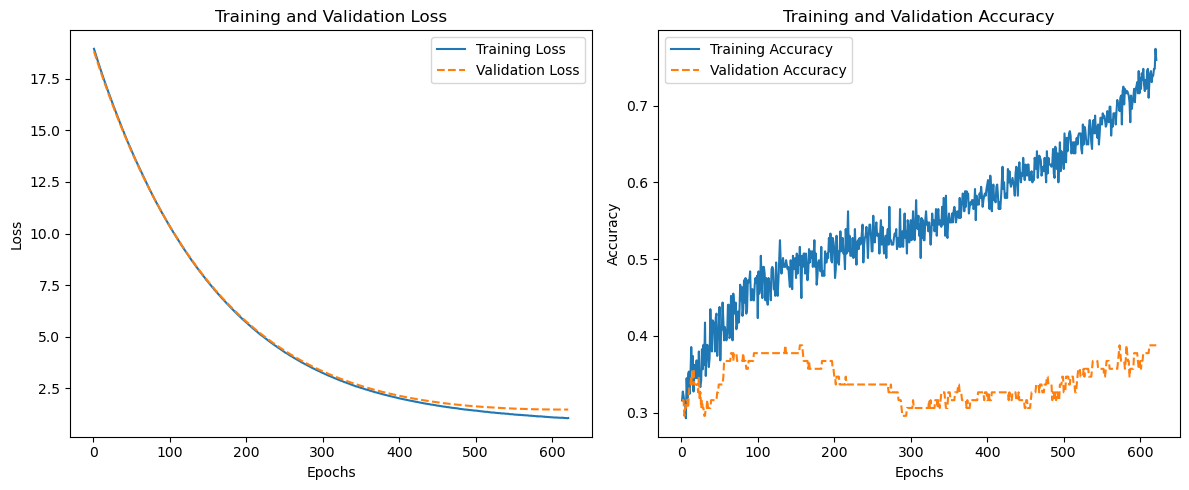

In [1315]:
# 獲取訓練損失值和準確率值
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# 獲取驗證集損失值和準確率值
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 獲取訓練週期數
epochs = range(1, len(train_loss) + 1)

# 繪製損失曲線
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.ylim(0, 10)

# 繪製準確率曲線
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.ylim(0.3, 0.55)

plt.tight_layout()
plt.show()

In [1316]:
model.evaluate([X_test_5, X_test_20, X_test_60], y_test)

2/2 [==============================] - 1s 232ms/step - loss: 1.5267 - accuracy: 0.4000


[1.5266594886779785, 0.4000000059604645]

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, classification_report,  ConfusionMatrixDisplay
import seaborn as sns 

2024-06-13 15:48:20.996288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-13 15:48:21.065890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-13 15:48:21.065911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 65ms/step


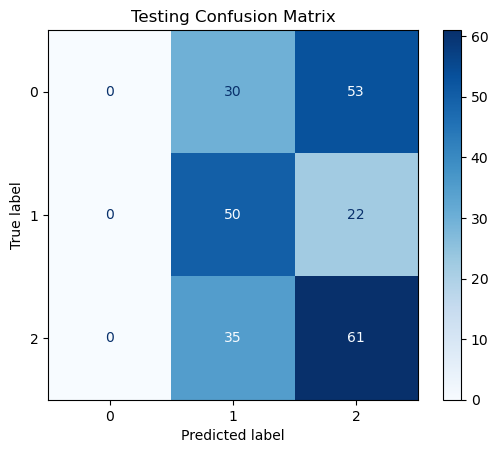

In [ ]:
y_test_pred = model.predict([X_test_5, X_test_20, X_test_60])
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)
cm_test = confusion_matrix(y_test_true_labels, y_test_pred_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Testing Confusion Matrix')
plt.show()

55/55 [==============================] - 1s 9ms/step


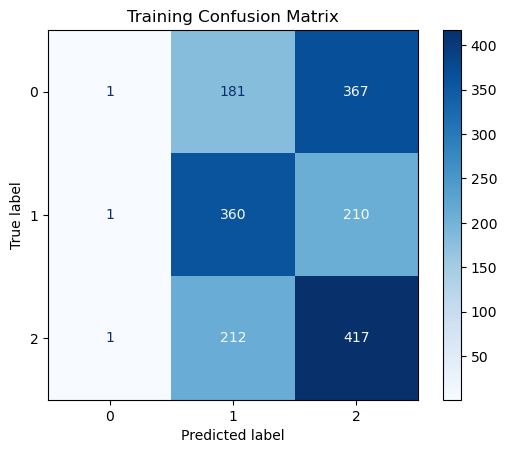

In [ ]:
y_train_pred = model.predict([X_train_5, X_train_20, X_train_60])
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_train_true_labels = np.argmax(y_train, axis=1)
cm_train = confusion_matrix(y_train_true_labels, y_train_pred_labels)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title('Training Confusion Matrix')
plt.show()

16/16 [==============================] - 0s 11ms/step


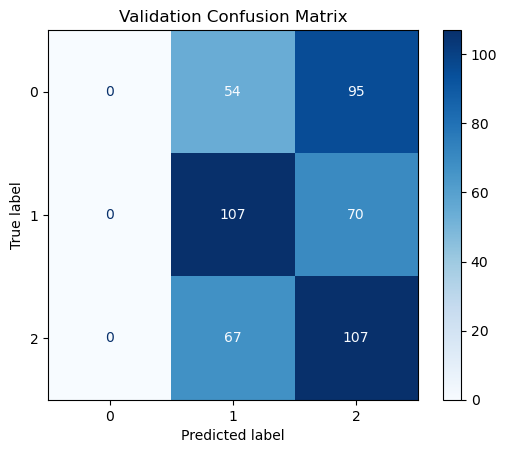

In [ ]:
y_val_pred = model.predict([X_val_5, X_val_20, X_val_60])
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)
cm_val = confusion_matrix(y_val_true_labels, y_val_pred_labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

In [ ]:
# 生成测试集的预测结果
y_test_pred = model.predict([X_test_5, X_test_20, X_test_60])
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# 生成分类报告
class_report = classification_report(y_test_true_labels, y_test_pred_labels, target_names=['Class -1', 'Class 0', 'Class 1'])
print(class_report)

8/8 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

    Class -1       0.00      0.00      0.00        83
     Class 0       0.43      0.69      0.53        72
     Class 1       0.45      0.64      0.53        96

    accuracy                           0.44       251
   macro avg       0.29      0.44      0.35       251
weighted avg       0.30      0.44      0.35       251



/Users/jeanhong/miniforge3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeanhong/miniforge3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeanhong/miniforge3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [ ]:
# # 儲存模型
# model.save('/Users/jeanhong/Desktop/MFCC/my_model_150_0.4.h5')

In [ ]:
# # 使用測試集評估模型性能
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")